[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1OpBHHs1LdThRABnKfY8b3o7f8T3fXWT5/view?usp=sharing)
# **UP School & Bitexen Women in Datathon 2024**

# **Abstract**

This notebook encompasses various analyses and visualizations of gender-related statistics from multiple datasets, including labour force participation rates, maternal mortality rates, and women's representation in top-income groups. Insights derived from these visualizations aim to highlight disparities and trends in gender equality across different countries and regions. For the dataset used in this analysis, visit the Kaggle page: [UP School & Bitexen Women in Datathon Dataset](https://www.kaggle.com/datasets/upschoolio/up-school-women-in-datathon-dataset). Additionally, classification modelling was conducted on the Placement dataset to explore factors influencing placement outcomes.

To understand women's economic participation and entrepreneurship comprehensively, the project also examines factors such as the gender wage gap, time dedicated to unpaid care work, and the Women Entrepreneurship Index. By analyzing data on the ratio of female-to-male labour force participation and indicators of women’s entrepreneurial activities, notable patterns emerge: developed countries generally exhibit higher levels of female labour force participation and entrepreneurship. In contrast, developing nations tend to show lower values in these areas. A positive correlation was observed between female labour force participation rates and the Women Entrepreneurship Index, suggesting a potential interplay between these factors. Visualizations further illustrate the intersection between unpaid care responsibilities, income disparities, and female economic engagement, shedding light on structural barriers faced by women globally.

The findings presented in this project aim to inform policymakers and stakeholders on the current landscape of gender equality in economic participation, with actionable insights to support female entrepreneurship and workforce engagement worldwide.


# **EDA (Exploratory Data Analysis)**

# **`1.` Required Libraries**

In [1]:
import os

import numpy as np
import pandas as pd

!pip install dash --quiet
import dash
from dash import dcc, html, Input, Output

import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

!pip install catboost --quiet
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score

from datetime import datetime

%matplotlib inline
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00


In [2]:
# Set Matplotlib defaults
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 6,4
rcParams.update({'font.size': 8})

# **`2.` Load Data**

In [ ]:
from google.colab import files
files.upload()

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set file permissions


In [5]:
# Download data
!kaggle datasets download -d upschoolio/up-school-women-in-datathon-dataset

import zipfile
with zipfile.ZipFile("up-school-women-in-datathon-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")


Dataset URL: https://www.kaggle.com/datasets/upschoolio/up-school-women-in-datathon-dataset
License(s): unknown
  0% 0.00/129k [00:00<?, ?B/s]
100% 129k/129k [00:00<00:00, 14.4MB/s]


In [6]:
# Load Data

dir = '/content/dataset/'

unpaid_care_work1 = pd.read_csv(os.path.join(dir, '1- female-to-male-ratio-of-time-devoted-to-unpaid-care-work.csv'))
top_income_groups = pd.read_csv(os.path.join(dir, '2- share-of-women-in-top-income-groups.csv'))
lfp_rates = pd.read_csv(os.path.join(dir,'3- ratio-of-female-to-male-labor-force-participation-rates-ilo-wdi.csv'))

unpaid_care_work4 = pd.read_csv(os.path.join(dir,'4- female-to-male-ratio-of-time-devoted-to-unpaid-care-work.csv'))
maternal_mortality = pd.read_csv(os.path.join(dir,'5- maternal-mortality.csv'))
gender_gap_average_wages = pd.read_csv(os.path.join(dir,'6- gender-gap-in-average-wages-ilo.csv'))

lf_w_entrepreneurship = pd.read_csv(os.path.join(dir,'Labor Force-Women Entrpreneurship.csv'), sep=';')
lfp_male = pd.read_csv(os.path.join(dir,'Labour Force Participation - Male.csv'))
lfp_female = pd.read_csv(os.path.join(dir,'Labour Force Participation Female.csv'))

placement = pd.read_csv(os.path.join(dir,'Placement.csv'))
women_ent_data3 = pd.read_csv(os.path.join(dir, 'Women Ent_Data3.csv'), sep=';')

print(f"{unpaid_care_work1.shape}, " +
      f"{top_income_groups.shape}, " +
      f"{lfp_rates.shape}, " +
      f"{unpaid_care_work4.shape}, " +
      f"{maternal_mortality.shape}, " +
      f"{gender_gap_average_wages.shape}, " +
      f"{lf_w_entrepreneurship.shape}, " +
      f"{lfp_male.shape}, " +
      f"{lfp_female.shape}, "+
      f"{placement.shape}, "+
      f"{women_ent_data3.shape}")

(69, 4), (168, 9), (6432, 4), (69, 4), (5800, 4), (413, 4), (51, 9), (195, 37), (195, 37), (215, 13), (51, 9)


The verification of datasets that are identical is conducted, and one of the duplicate datasets will be utilized for further analysis.

In [7]:
are_equal1 = women_ent_data3.equals(lf_w_entrepreneurship)
print(f"Are the two datasets equal? {are_equal1}")

are_equal2 = unpaid_care_work1.equals(unpaid_care_work4)
print(f"Are the two datasets equal? {are_equal2}")

Are the two datasets equal? True
Are the two datasets equal? True


# **`3.` Data Cleaning**

**Gender-Based Labor and Workforce Participation**

- **ratio-of-female-to-male-labor-force-participation-rates-ilo-wdi**

In [8]:
lfp_rates.head()

,Entity,Code,Year,Ratio of female to male labor force participation rate (%) (modeled ILO estimate)
0,Afghanistan,AFG,1990,19.604805
1,Afghanistan,AFG,1991,19.713380
2,Afghanistan,AFG,1992,19.803307
3,Afghanistan,AFG,1993,19.844606
4,Afghanistan,AFG,1994,19.884710


In [9]:
lfp_rates.Entity.nunique(), lfp_rates.Code.nunique()

(201, 187)

In [10]:
lfp_rates_nan = lfp_rates[lfp_rates['Code'].isna()]['Entity'].unique()
lfp_rates_nan

array(['East Asia and Pacific (WB)', 'Europe and Central Asia (WB)',
       'European Union (27)', 'High-income countries',
       'Latin America and Caribbean (WB)', 'Low-income countries',
       'Lower-middle-income countries',
       'Middle East and North Africa (WB)', 'Middle-income countries',
       'North America (WB)', 'South Asia (WB)', 'Sub-Saharan Africa (WB)',
       'Upper-middle-income countries', 'West Bank and Gaza'],
      dtype=object)

In [11]:
# Fill the Code field according to entity names
custom_codes = {
    'East Asia and Pacific (WB)': 'EAP',
    'Europe and Central Asia (WB)': 'ECA',
    'European Union (27)': 'EU27',
    'High-income countries': 'HIC',
    'Low-income countries': 'LIC',
    'Lower-middle-income countries': 'LMIC',
    'Middle East and North Africa (WB)': 'MENA',
    'Middle-income countries': 'MIC',
    'North America (WB)': 'NA',
    'South Asia (WB)': 'SA',
    'Sub-Saharan Africa (WB)': 'SSA',
    'Upper-middle-income countries': 'UMIC',
    'West Bank and Gaza': 'WBG',
    'Latin America and Caribbean (WB)': 'LAC'
}
# Assign the appropriate code to each Entity
lfp_rates['Code'] = lfp_rates['Entity'].map(custom_codes).fillna(lfp_rates['Code'])
lfp_rates.Entity.nunique(), lfp_rates.Code.nunique()

(201, 201)

In [12]:
# [code for code in labor_force_part_rates['Code'].unique() if str(code).startswith('U')]
[entity for entity in lfp_rates['Entity'].unique() if 'Korea' in str(entity)]

['North Korea', 'South Korea']

In [13]:
lfp_rates[lfp_rates['Entity'] == 'South Korea'].head()

,Entity,Code,Year,Ratio of female to male labor force participation rate (%) (modeled ILO estimate)
5280,South Korea,KOR,1990,63.477898
5281,South Korea,KOR,1991,62.802166
5282,South Korea,KOR,1992,62.278020
5283,South Korea,KOR,1993,62.192284
5284,South Korea,KOR,1994,62.666770


- **Labor Force-Women Entrpreneurship**

In [14]:
lf_w_entrepreneurship.drop(columns=['No'], inplace=True)
lf_w_entrepreneurship.head()

,Country,Level of development,European Union Membership,Currency,Women Entrepreneurship Index,Entrepreneurship Index,Inflation rate,Female Labor Force Participation Rate
0,Austria,Developed,Member,Euro,54.9,64.9,0.90,67.1
1,Belgium,Developed,Member,Euro,63.6,65.5,0.60,58.0
2,Estonia,Developed,Member,Euro,55.4,60.2,-0.88,68.5
3,Finland,Developed,Member,Euro,66.4,65.7,-0.20,67.7
4,France,Developed,Member,Euro,68.8,67.3,0.00,60.6


In [15]:
lf_w_entrepreneurship.isna().sum().sum(), lf_w_entrepreneurship.Country.nunique()

(0, 51)

- **Labour Force Participation - Female**

In [16]:
lfp_female.head()

,ISO3,Country,Continent,Hemisphere,HDI Rank (2021),"Labour force participation rate, female (% ages 15 and older) (1990)","Labour force participation rate, female (% ages 15 and older) (1991)","Labour force participation rate, female (% ages 15 and older) (1992)","Labour force participation rate, female (% ages 15 and older) (1993)","Labour force participation rate, female (% ages 15 and older) (1994)",...,"Labour force participation rate, female (% ages 15 and older) (2012)","Labour force participation rate, female (% ages 15 and older) (2013)","Labour force participation rate, female (% ages 15 and older) (2014)","Labour force participation rate, female (% ages 15 and older) (2015)","Labour force participation rate, female (% ages 15 and older) (2016)","Labour force participation rate, female (% ages 15 and older) (2017)","Labour force participation rate, female (% ages 15 and older) (2018)","Labour force participation rate, female (% ages 15 and older) (2019)","Labour force participation rate, female (% ages 15 and older) (2020)","Labour force participation rate, female (% ages 15 and older) (2021)"
0,AFG,Afghanistan,Asia,Northern Hemisphere,180.0,15.180,15.214,15.223,15.197,15.178,...,15.879,16.794,17.749,18.746,19.798,20.887,21.228,21.566,16.189,14.848
1,AGO,Angola,Africa,Southern Hemisphere,148.0,75.408,75.381,75.369,75.371,75.387,...,74.834,74.833,74.843,74.864,74.882,74.912,74.955,75.011,73.618,73.968
2,ALB,Albania,Europe,Northern Hemisphere,67.0,51.364,54.727,55.608,54.638,53.825,...,48.778,43.598,43.733,46.898,49.676,49.510,51.189,52.723,49.786,50.733
3,AND,Andorra,Europe,Northern Hemisphere,40.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ARE,United Arab Emirates,Asia,Northern Hemisphere,26.0,29.083,29.779,30.272,30.944,31.121,...,44.718,46.190,47.659,49.072,50.373,51.947,48.951,48.923,45.703,46.542


In [17]:
def find_years(df, sex):
    year_columns = [col for col in df.columns if f'Labour force participation rate, {sex}' in col]
    years = [int(col.split('(')[-1].split(')')[0].strip()) for col in year_columns]

    min_year = min(years)
    max_year = max(years)
    return min_year, max_year

min_year, max_year = find_years(lfp_female, 'female')
print("Min year:", min_year)
print("Max year:", max_year)

Min year: 1990
Max year: 2021


In [18]:
lfp_female.ISO3.nunique(), lfp_female.Country.nunique(), lfp_female.isna().sum().sum()

(195, 195, 484)

In [19]:
lfp_female[lfp_female['HDI Rank (2021)'].isna()]

,ISO3,Country,Continent,Hemisphere,HDI Rank (2021),"Labour force participation rate, female (% ages 15 and older) (1990)","Labour force participation rate, female (% ages 15 and older) (1991)","Labour force participation rate, female (% ages 15 and older) (1992)","Labour force participation rate, female (% ages 15 and older) (1993)","Labour force participation rate, female (% ages 15 and older) (1994)",...,"Labour force participation rate, female (% ages 15 and older) (2012)","Labour force participation rate, female (% ages 15 and older) (2013)","Labour force participation rate, female (% ages 15 and older) (2014)","Labour force participation rate, female (% ages 15 and older) (2015)","Labour force participation rate, female (% ages 15 and older) (2016)","Labour force participation rate, female (% ages 15 and older) (2017)","Labour force participation rate, female (% ages 15 and older) (2018)","Labour force participation rate, female (% ages 15 and older) (2019)","Labour force participation rate, female (% ages 15 and older) (2020)","Labour force participation rate, female (% ages 15 and older) (2021)"
108,MCO,Monaco,Europe,Northern Hemisphere,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,NRU,Nauru,Oceania,Southern Hemisphere,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,PRK,North Korea,Asia,Northern Hemisphere,NaN,76.596,76.833,77.201,77.465,77.625,...,78.050,78.023,77.997,78.072,77.919,78.105,78.327,78.408,77.501,77.185
158,SOM,Somalia,Africa,Northern Hemisphere,NaN,21.712,21.620,21.555,21.506,21.442,...,20.571,20.660,20.753,20.838,20.915,20.980,21.040,21.106,20.833,20.901


In [20]:
lfp_female_nan_countries = lfp_female[lfp_female.isna().any(axis=1)]['Country'].tolist()
lfp_female_nan_countries

['Andorra',
 'Antigua and Barbuda',
 'Dominica',
 'Micronesia',
 'Grenada',
 'Kiribati',
 'Saint Kitts and Nevis',
 'Liechtenstein',
 'Monaco',
 'Marshall Islands',
 'Nauru',
 'Palau',
 'North Korea',
 'San Marino',
 'Somalia',
 'Seychelles',
 'Tuvalu']

In [21]:
# Drop nan data
lfp_female_cleaned = lfp_female[~lfp_female['Country'].isin(lfp_female_nan_countries)]
lfp_female_cleaned.isna().sum().sum()

0

In [22]:
lfp_female_cleaned_sorted = lfp_female_cleaned.sort_values(by='HDI Rank (2021)', ascending=False)
lfp_female_cleaned_sorted.head()

,ISO3,Country,Continent,Hemisphere,HDI Rank (2021),"Labour force participation rate, female (% ages 15 and older) (1990)","Labour force participation rate, female (% ages 15 and older) (1991)","Labour force participation rate, female (% ages 15 and older) (1992)","Labour force participation rate, female (% ages 15 and older) (1993)","Labour force participation rate, female (% ages 15 and older) (1994)",...,"Labour force participation rate, female (% ages 15 and older) (2012)","Labour force participation rate, female (% ages 15 and older) (2013)","Labour force participation rate, female (% ages 15 and older) (2014)","Labour force participation rate, female (% ages 15 and older) (2015)","Labour force participation rate, female (% ages 15 and older) (2016)","Labour force participation rate, female (% ages 15 and older) (2017)","Labour force participation rate, female (% ages 15 and older) (2018)","Labour force participation rate, female (% ages 15 and older) (2019)","Labour force participation rate, female (% ages 15 and older) (2020)","Labour force participation rate, female (% ages 15 and older) (2021)"
160,SSD,South Sudan,Africa,Northern Hemisphere,191.0,71.567,71.517,71.514,71.541,71.554,...,71.880,71.951,72.035,72.136,72.207,72.281,72.363,72.451,69.228,70.440
169,TCD,Chad,Africa,Northern Hemisphere,190.0,64.562,64.480,64.415,64.365,63.770,...,52.403,51.748,51.091,50.433,49.777,49.120,48.462,48.549,46.443,46.914
126,NER,Niger,Africa,Northern Hemisphere,189.0,69.503,69.477,69.458,69.445,69.440,...,66.694,64.529,62.332,62.330,62.320,62.319,62.326,62.339,61.738,61.730
28,CAF,Central African Republic,Africa,Northern Hemisphere,188.0,64.052,64.044,64.050,64.066,64.092,...,63.753,63.695,63.654,63.627,63.687,63.764,63.853,63.948,62.916,63.312
11,BDI,Burundi,Africa,Southern Hemisphere,187.0,90.555,90.075,89.573,89.049,88.502,...,80.765,80.330,79.888,79.869,79.859,79.861,79.875,79.902,79.143,78.991


- **Labour Force Participation - Male**

In [23]:
lfp_male.head()

,ISO3,Country,Continent,Hemisphere,HDI Rank (2021),"Labour force participation rate, male (% ages 15 and older) (1990)","Labour force participation rate, male (% ages 15 and older) (1991)","Labour force participation rate, male (% ages 15 and older) (1992)","Labour force participation rate, male (% ages 15 and older) (1993)","Labour force participation rate, male (% ages 15 and older) (1994)",...,"Labour force participation rate, male (% ages 15 and older) (2012)","Labour force participation rate, male (% ages 15 and older) (2013)","Labour force participation rate, male (% ages 15 and older) (2014)","Labour force participation rate, male (% ages 15 and older) (2015)","Labour force participation rate, male (% ages 15 and older) (2016)","Labour force participation rate, male (% ages 15 and older) (2017)","Labour force participation rate, male (% ages 15 and older) (2018)","Labour force participation rate, male (% ages 15 and older) (2019)","Labour force participation rate, male (% ages 15 and older) (2020)","Labour force participation rate, male (% ages 15 and older) (2021)"
0,AFG,Afghanistan,Asia,Northern Hemisphere,180.0,77.430,77.176,76.871,76.580,76.330,...,76.420,75.588,74.737,73.875,73.045,72.183,72.023,71.863,65.580,66.515
1,AGO,Angola,Africa,Southern Hemisphere,148.0,79.292,79.367,79.405,79.409,79.381,...,79.922,79.930,79.912,79.865,79.827,79.756,79.653,79.519,78.798,79.071
2,ALB,Albania,Europe,Northern Hemisphere,67.0,72.510,75.143,75.858,75.222,74.680,...,65.197,61.180,62.984,63.957,64.800,66.440,67.247,67.742,65.631,66.154
3,AND,Andorra,Europe,Northern Hemisphere,40.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ARE,United Arab Emirates,Asia,Northern Hemisphere,26.0,91.714,91.894,91.989,92.196,92.168,...,89.976,90.557,91.098,91.509,91.697,91.559,90.621,90.686,87.191,88.003


In [24]:
min_year, max_year = find_years(lfp_male, 'male')
print("Min year:", min_year)
print("Max year:", max_year)

Min year: 1990
Max year: 2021


In [25]:
lfp_male.ISO3.nunique(), lfp_male.Country.nunique(), lfp_male.isna().sum().sum()

(195, 195, 484)

In [26]:
lfp_male[lfp_male['HDI Rank (2021)'].isna()]

,ISO3,Country,Continent,Hemisphere,HDI Rank (2021),"Labour force participation rate, male (% ages 15 and older) (1990)","Labour force participation rate, male (% ages 15 and older) (1991)","Labour force participation rate, male (% ages 15 and older) (1992)","Labour force participation rate, male (% ages 15 and older) (1993)","Labour force participation rate, male (% ages 15 and older) (1994)",...,"Labour force participation rate, male (% ages 15 and older) (2012)","Labour force participation rate, male (% ages 15 and older) (2013)","Labour force participation rate, male (% ages 15 and older) (2014)","Labour force participation rate, male (% ages 15 and older) (2015)","Labour force participation rate, male (% ages 15 and older) (2016)","Labour force participation rate, male (% ages 15 and older) (2017)","Labour force participation rate, male (% ages 15 and older) (2018)","Labour force participation rate, male (% ages 15 and older) (2019)","Labour force participation rate, male (% ages 15 and older) (2020)","Labour force participation rate, male (% ages 15 and older) (2021)"
108,MCO,Monaco,Europe,Northern Hemisphere,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,NRU,Nauru,Oceania,Southern Hemisphere,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,PRK,North Korea,Asia,Northern Hemisphere,NaN,86.589,86.634,86.696,86.73,86.747,...,86.754,86.75,86.745,86.750,86.736,86.751,86.764,86.768,86.116,86.141
158,SOM,Somalia,Africa,Northern Hemisphere,NaN,45.036,45.300,45.492,45.64,45.822,...,48.553,48.34,48.113,47.907,47.718,47.558,47.408,47.240,46.868,46.978


In [27]:
lfp_male_nan_countries = lfp_male[lfp_male.isna().any(axis=1)]['Country'].tolist()
lfp_male_nan_countries

['Andorra',
 'Antigua and Barbuda',
 'Dominica',
 'Micronesia',
 'Grenada',
 'Kiribati',
 'Saint Kitts and Nevis',
 'Liechtenstein',
 'Monaco',
 'Marshall Islands',
 'Nauru',
 'Palau',
 'North Korea',
 'San Marino',
 'Somalia',
 'Seychelles',
 'Tuvalu']

In [28]:
# Drop nan data
lfp_male_cleaned = lfp_male[~lfp_male['Country'].isin(lfp_male_nan_countries)]
lfp_male_cleaned.isna().sum().sum()

0

In [29]:
lfp_male_cleaned['HDI Rank (2021)'].max(), lfp_male_cleaned['HDI Rank (2021)'].min()

(191.0, 1.0)

In [30]:
lfp_male_cleaned_sorted = lfp_male_cleaned.sort_values(by='HDI Rank (2021)', ascending=False)
lfp_male_cleaned_sorted.head(3)

,ISO3,Country,Continent,Hemisphere,HDI Rank (2021),"Labour force participation rate, male (% ages 15 and older) (1990)","Labour force participation rate, male (% ages 15 and older) (1991)","Labour force participation rate, male (% ages 15 and older) (1992)","Labour force participation rate, male (% ages 15 and older) (1993)","Labour force participation rate, male (% ages 15 and older) (1994)",...,"Labour force participation rate, male (% ages 15 and older) (2012)","Labour force participation rate, male (% ages 15 and older) (2013)","Labour force participation rate, male (% ages 15 and older) (2014)","Labour force participation rate, male (% ages 15 and older) (2015)","Labour force participation rate, male (% ages 15 and older) (2016)","Labour force participation rate, male (% ages 15 and older) (2017)","Labour force participation rate, male (% ages 15 and older) (2018)","Labour force participation rate, male (% ages 15 and older) (2019)","Labour force participation rate, male (% ages 15 and older) (2020)","Labour force participation rate, male (% ages 15 and older) (2021)"
160,SSD,South Sudan,Africa,Northern Hemisphere,191.0,77.018,77.142,77.151,77.083,77.052,...,76.215,76.046,75.844,75.606,75.437,75.262,75.071,74.867,73.154,73.574
169,TCD,Chad,Africa,Northern Hemisphere,190.0,80.022,80.242,80.409,80.534,80.225,...,73.926,73.534,73.138,72.738,72.335,71.929,71.518,71.283,69.437,69.927
126,NER,Niger,Africa,Northern Hemisphere,189.0,90.009,90.026,89.969,89.866,89.741,...,88.974,87.143,85.109,85.052,85.032,84.981,84.906,84.812,83.994,84.267


In [31]:
lfp_male_cleaned_sorted.tail(3)

,ISO3,Country,Continent,Hemisphere,HDI Rank (2021),"Labour force participation rate, male (% ages 15 and older) (1990)","Labour force participation rate, male (% ages 15 and older) (1991)","Labour force participation rate, male (% ages 15 and older) (1992)","Labour force participation rate, male (% ages 15 and older) (1993)","Labour force participation rate, male (% ages 15 and older) (1994)",...,"Labour force participation rate, male (% ages 15 and older) (2012)","Labour force participation rate, male (% ages 15 and older) (2013)","Labour force participation rate, male (% ages 15 and older) (2014)","Labour force participation rate, male (% ages 15 and older) (2015)","Labour force participation rate, male (% ages 15 and older) (2016)","Labour force participation rate, male (% ages 15 and older) (2017)","Labour force participation rate, male (% ages 15 and older) (2018)","Labour force participation rate, male (% ages 15 and older) (2019)","Labour force participation rate, male (% ages 15 and older) (2020)","Labour force participation rate, male (% ages 15 and older) (2021)"
82,ISL,Iceland,Europe,Northern Hemisphere,3.0,80.827,81.134,81.717,79.907,79.604,...,77.847,78.695,80.390,80.949,82.329,80.969,79.529,78.493,76.508,70.463
130,NOR,Norway,Europe,Northern Hemisphere,2.0,70.218,68.905,68.944,68.403,68.859,...,69.013,68.440,66.843,67.653,66.916,65.955,66.408,66.173,65.593,71.950
30,CHE,Switzerland,Europe,Northern Hemisphere,1.0,80.358,80.857,80.224,80.282,79.251,...,74.488,74.188,74.138,74.219,74.491,74.459,74.226,73.639,73.384,72.705


In [32]:
merged_fe_male = pd.merge(lfp_female_cleaned, lfp_male_cleaned, on='Country', how='inner', suffixes=('_f', '_m'))
merged_fe_male.rename(columns={'Continent_f': 'Continent', 'Hemisphere_f': 'Hemisphere', 'HDI Rank (2021)_f': 'HDI Rank (2021)'}, inplace=True)
merged_fe_male.head(3)

,ISO3_f,Country,Continent,Hemisphere,HDI Rank (2021),"Labour force participation rate, female (% ages 15 and older) (1990)","Labour force participation rate, female (% ages 15 and older) (1991)","Labour force participation rate, female (% ages 15 and older) (1992)","Labour force participation rate, female (% ages 15 and older) (1993)","Labour force participation rate, female (% ages 15 and older) (1994)",...,"Labour force participation rate, male (% ages 15 and older) (2012)","Labour force participation rate, male (% ages 15 and older) (2013)","Labour force participation rate, male (% ages 15 and older) (2014)","Labour force participation rate, male (% ages 15 and older) (2015)","Labour force participation rate, male (% ages 15 and older) (2016)","Labour force participation rate, male (% ages 15 and older) (2017)","Labour force participation rate, male (% ages 15 and older) (2018)","Labour force participation rate, male (% ages 15 and older) (2019)","Labour force participation rate, male (% ages 15 and older) (2020)","Labour force participation rate, male (% ages 15 and older) (2021)"
0,AFG,Afghanistan,Asia,Northern Hemisphere,180.0,15.180,15.214,15.223,15.197,15.178,...,76.420,75.588,74.737,73.875,73.045,72.183,72.023,71.863,65.580,66.515
1,AGO,Angola,Africa,Southern Hemisphere,148.0,75.408,75.381,75.369,75.371,75.387,...,79.922,79.930,79.912,79.865,79.827,79.756,79.653,79.519,78.798,79.071
2,ALB,Albania,Europe,Northern Hemisphere,67.0,51.364,54.727,55.608,54.638,53.825,...,65.197,61.180,62.984,63.957,64.800,66.440,67.247,67.742,65.631,66.154


**Gender-Based Time Use and Unpaid Care Work**

- **female-to-male-ratio-of-time-devoted-to-unpaid-care-work**

In [33]:
unpaid_care_work1.head()

,Entity,Code,Year,Female to male ratio of time devoted to unpaid care work (OECD (2014))
0,Albania,ALB,2014,7.21
1,Algeria,DZA,2014,6.75
2,Argentina,ARG,2014,2.88
3,Armenia,ARM,2014,5.24
4,Australia,AUS,2014,1.81


In [34]:
unpaid_care_work1.Entity.nunique(), unpaid_care_work1.Code.nunique()

(69, 68)

In [35]:
unpaid_care_work1.isna().sum()

,0
Entity,0
Code,1
Year,0
Female to male ratio of time devoted to unpaid care work (OECD (2014)),0


In [36]:
unpaid_care_work1[unpaid_care_work1['Code'].isna()]

,Entity,Code,Year,Female to male ratio of time devoted to unpaid care work (OECD (2014))
33,Korea,NaN,2014,5.28


As indicated in the provided ILO [link](https://www.ilo.org/regions-and-countries), South Korea is one of the countries represented in the International Labour Organization's data on unpaid care work. This information was used as a reference to correct the inaccurate data.

In [37]:
# Fix corrupted values
unpaid_care_work1.loc[unpaid_care_work1['Entity'] == 'Korea', 'Entity'] = 'South Korea'
unpaid_care_work1.loc[unpaid_care_work1['Entity'] == 'South Korea', 'Code'] = 'KOR'

**Gender Income Disparities**

- **top_income_groups**

In [38]:
top_income_groups.head()

,Entity,Code,Year,Share of women in top 0.1%,Share of women in top 0.25%,Share of women in top 0.5%,Share of women in top 1%,Share of women in top 10%,Share of women in top 5%
0,Australia,AUS,2000,14.2,NaN,NaN,18.3,24.9,21.1
1,Australia,AUS,2001,13.2,NaN,NaN,18.4,25.1,21.4
2,Australia,AUS,2002,13.5,NaN,NaN,18.8,25.1,21.5
3,Australia,AUS,2003,14.4,NaN,NaN,19.1,25.1,21.6
4,Australia,AUS,2004,15.2,NaN,NaN,19.6,25.5,22.2


In [39]:
top_income_groups.Entity.unique(), top_income_groups.Code.unique()

(array(['Australia', 'Canada', 'Denmark', 'Italy', 'New Zealand', 'Norway',
        'Spain', 'UK'], dtype=object),
 array(['AUS', 'CAN', 'DNK', 'ITA', 'NZL', 'NOR', 'ESP', nan], dtype=object))

In [40]:
top_income_groups.isna().sum()

,0
Entity,0
Code,20
Year,0
Share of women in top 0.1%,37
Share of women in top 0.25%,131
Share of women in top 0.5%,86
Share of women in top 1%,1
Share of women in top 10%,0
Share of women in top 5%,0


In [41]:
top_income_groups.Entity.unique()

array(['Australia', 'Canada', 'Denmark', 'Italy', 'New Zealand', 'Norway',
       'Spain', 'UK'], dtype=object)

In [42]:
top_income_groups[top_income_groups['Code'].isna()].head()

,Entity,Code,Year,Share of women in top 0.1%,Share of women in top 0.25%,Share of women in top 0.5%,Share of women in top 1%,Share of women in top 10%,Share of women in top 5%
148,UK,NaN,1995,9.6,9.9,9.8,10.7,19.9,15.6
149,UK,NaN,1996,8.6,10.0,12.2,13.2,20.6,16.7
150,UK,NaN,1997,10.7,13.1,12.5,13.5,21.5,17.6
151,UK,NaN,1998,10.4,10.8,12.1,13.4,21.4,17.7
152,UK,NaN,1999,10.0,10.6,11.8,13.4,21.9,18.6


In [43]:
# Fix corrupted values
top_income_groups.loc[top_income_groups['Entity'] == 'UK', 'Entity'] = 'United Kingdom'
top_income_groups.loc[top_income_groups['Entity'] == 'United Kingdom', 'Code'] = 'UK'

- **gender-gap-in-average-wages-ilo**

In [44]:
gender_gap_average_wages.head()

,Entity,Code,Year,Gender wage gap (%)
0,Argentina,ARG,1986,15.79
1,Argentina,ARG,1987,12.50
2,Argentina,ARG,1988,11.31
3,Argentina,ARG,1991,6.71
4,Argentina,ARG,1992,8.33


In [45]:
gender_gap_average_wages.Entity.nunique(), gender_gap_average_wages.Code.nunique(), gender_gap_average_wages.isna().sum().sum()

(64, 64, 0)

**Health and Social Well-being**

- **maternal_mortality**

In [46]:
maternal_mortality.head()

,Entity,Code,Year,Maternal Mortality Ratio (Gapminder (2010) and World Bank (2015))
0,Afghanistan,AFG,2000,1450.0
1,Afghanistan,AFG,2001,1390.0
2,Afghanistan,AFG,2002,1300.0
3,Afghanistan,AFG,2003,1240.0
4,Afghanistan,AFG,2004,1180.0


In [47]:
maternal_mortality.Entity.nunique(), maternal_mortality.Code.nunique()

(200, 186)

In [48]:
maternal_mortality_nan = maternal_mortality[maternal_mortality['Code'].isna()]['Entity'].unique()
maternal_mortality_nan

array(['Caribbean small states', 'East Asia & Pacific (WB)',
       'Europe & Central Asia (WB)', 'High income (WB)',
       'Latin America & Caribbean (WB)', 'Low & middle income (WB)',
       'Low income (WB)', 'Lower middle income (WB)',
       'Middle East & North Africa (WB)', 'Middle income (WB)',
       'North America (WB)', 'South Asia (WB)', 'Sub-Saharan Africa (WB)',
       'Upper middle income (WB)'], dtype=object)

In [49]:
entity_replacements = {
    'High income (WB)': 'High-income countries',
    'Low income (WB)': 'Low-income countries',
    'Lower middle income (WB)': 'Lower-middle-income countries',
    'Middle income (WB)': 'Middle-income countries',
    'Upper middle income (WB)': 'Upper-middle-income countries',
    'Latin America & Caribbean (WB)': 'Latin America and Caribbean (WB)',
    'Caribbean small states': 'Caribbean small states',
    # 'Low and middle income (WB)': 'Low and middle income countries'
}
custom_codes['Caribbean small states'] = 'CSS'
custom_codes['Low and middle income (WB)'] = 'LMI'

maternal_mortality['Entity'] = maternal_mortality['Entity'].replace(entity_replacements)
maternal_mortality['Entity'] = maternal_mortality['Entity'].str.replace('&', 'and')
maternal_mortality['Code'] = maternal_mortality['Entity'].map(custom_codes).fillna(maternal_mortality['Code'])
maternal_mortality.Entity.nunique(), maternal_mortality.Code.nunique()

(200, 200)

**Employment and Placement**

In [50]:
placement.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


In [51]:
placement.isna().sum().sum()

0

# **`4.`  Data Analysis**

**Top 10 Countries with Highest Female to Male Labor Force Participation Ratio**

The ten (10) countries with the highest change in the labor force participation values ​​of women compared to men over the years are shown in the visual below.

In [52]:
ratio_feature = 'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)'

# Calculate the women's economic participation rate for each country
lfp_country_ratios = lfp_rates.groupby('Entity')[ratio_feature].mean().reset_index()

# Sort countries by female participation rate in economic life
sorted_countries = lfp_country_ratios.sort_values(by=ratio_feature, ascending=False)

# 10 countries with the highest rates
top_countries = sorted_countries.head(10)
fig = px.bar(
    top_countries,
    x=ratio_feature,
    y='Entity',
    orientation='h',
    title='Top 10 Countries with Highest Female to Male Labor Force Participation Ratio',
    labels={ratio_feature: 'Ratio (%)', 'Entity': 'Country'},
    color_discrete_sequence=['skyblue']
)

# Layout settings
fig.update_layout(
    xaxis_title='Ratio (%)',
    yaxis_title='Country',
    height=400
)

**Comparison of Female Economic Participation Rate and Women Entrepreneurship Index Across Countries**

It has been observed that in developed countries, women's labor force participation and entrepreneurship rates are generally higher, while in developing countries, these rates tend to be lower. The positive relationship between women's labor force participation rate and the entrepreneurship index suggests a potential interaction between these two factors.

In [53]:
# Merge data
merged_lf_ent_rates = pd.merge(
    lfp_country_ratios,
    lf_w_entrepreneurship, left_on='Entity', right_on='Country')
merged_lf_ent_rates.drop(columns=['Country'], inplace=True)

# Sort data
sorted_merged = merged_lf_ent_rates.sort_values(by=ratio_feature, ascending=False).reset_index(drop=True)

# Plot
fig = px.scatter(
    sorted_merged,
    x=ratio_feature,
    y='Women Entrepreneurship Index',
    color='Level of development',
    symbol='European Union Membership',
    title="Women’s Economic Participation Rate vs. Women Entrepreneurship Index",
    labels={
        ratio_feature: 'Female Economic Participation Rate (%)',
        'Women Entrepreneurship Index': 'Women Entrepreneurship Index'
    }
)
fig.update_layout(width=1400, height=600)
fig.show()

**Female to Male Labor Force Participation Rate (2020 vs 2021)**

The countries that experienced an increase in the ratio of female to male labor force participation between 2020 and 2021 are listed below, ranked from the largest to smallest improvement. By calculating the difference in participation rates for each country, the results highlight those where female labor force participation increased relative to males. **Bolivia** saw the most significant positive change, indicating a substantial rise in female participation during this period. **Slovakia, Hungary, and Peru** also demonstrated notable improvements. These increases suggest progress in closing the gender gap in labor force participation within these countries.

In [54]:
# Filter the data for 2020 and 2021
lfp_2020 = lfp_rates[lfp_rates['Year'] == 2020]
lfp_2021 = lfp_rates[lfp_rates['Year'] == 2021]

# Merge the data by country names
merged_lf = pd.merge(lfp_2020, lfp_2021, on='Entity', suffixes=('_2020', '_2021'))
# Calculate the difference in matching countries
merged_lf['Difference'] = merged_lf['Ratio of female to male labor force participation rate (%) (modeled ILO estimate)_2021'] - merged_lf['Ratio of female to male labor force participation rate (%) (modeled ILO estimate)_2020']
merged_lf.dropna(inplace=True)

# Sort data by 'Difference'
top_30 = merged_lf.nlargest(30, 'Difference')

# Convert data to long format
top_30_long = pd.melt(
    top_30,
    id_vars=['Entity'],
    value_vars=['Ratio of female to male labor force participation rate (%) (modeled ILO estimate)_2020',
                'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)_2021'],
    var_name='Year',
    value_name='Participation Rate (%)'
)
top_30_long['Year'] = top_30_long['Year'].str.extract('(\d{4})')

# Plot
fig = px.line(
    top_30_long,
    x='Entity',
    y='Participation Rate (%)',
    color='Year',
    title='Female to Male Labor Force Participation Rate (2020 vs 2021)',
    labels={'Entity': 'Country', 'Participation Rate (%)': 'Participation Rate (%)'}
)
fig.update_layout(
    xaxis_title='Country',
    yaxis_title='Participation Rate (%)',
    xaxis=dict(tickangle=90),
    height=600
)


**Gender-Specific Statistics and Percentiles for Labor Force Participation Rates**

The 25th percentile for female participation rates across the countries is approximately 41.31%, while the 75th percentile is around 60.21%. For males, the 25th percentile of participation rates is around 67.45%, and the 75th percentile is approximately 79.03%. The data suggests a clear gender disparity. While male labor force participation rates are generally higher and more consistent across countries, female participation shows much more variability, with significant differences depending on the country and region. This discrepancy is critical to understanding broader gender inequality in labor markets, with women being underrepresented in the workforce in many countries.

In [55]:
def calculate_statistics(row, gender):
    # Filter data for the relevant gender (exclude NaN values)
    columns = [col for col in row.index if gender in col]
    values = row[columns].dropna()

    # Compute statistics if values exist and store them in new columns
    if len(values) > 0:
        row[f'Mean_{gender}'] = values.mean()
        row[f'Median_{gender}'] = values.median()
        row[f'Std_{gender}'] = values.std()
        row[f'Min_{gender}'] = values.min()
        row[f'Max_{gender}'] = values.max()
    return row

# Apply to calculate female and male statistics
female = lfp_female_cleaned.apply(lambda row: calculate_statistics(row, "female"), axis=1)
male = lfp_male_cleaned.apply(lambda row: calculate_statistics(row, "male"), axis=1)

# 25/75th percentile - female
per_25_f = female['Mean_female'].quantile(0.25)
per_75_f = female['Mean_female'].quantile(0.75)

# 25/75. percentile - male
per_25_m = male['Mean_male'].quantile(0.25)
per_75_m = male['Mean_male'].quantile(0.75)

per_25_f, per_75_f, per_25_m, per_75_m

(41.3103125, 60.208828125, 67.44703125000001, 79.026171875)

**Labour Force Participation Rate Over the Years**

The chart illustrates the labor force participation rates for males and females from **1990 to 2021**. Over the years, the participation rate for males shows a gradual decline, while the female participation rate remains relatively lower but with a slight upward trend until 2020. Notably, a significant dip in both male and female labor force participation is observed in 2020, which is likely associated with the impact of the COVID-19 pandemic.

In [56]:
# Calculate average labor force participation rates for female and male
avg_female_rates = female[[col for col in female.columns if "Labour force participation rate, female" in col]].mean(axis=0)
avg_male_rates = male[[col for col in male.columns if "Labour force participation rate, male" in col]].mean(axis=0)

# DataFrame for plotting
years = [str(year) for year in range(min_year, max_year + 1)]
avg_fe_male = pd.DataFrame({
    'Year': years,
    'Female Participation Rate': avg_female_rates.values,
    'Male Participation Rate': avg_male_rates.values
})

# Melt the DataFrame for easier plotting
avg_fe_male_melted = avg_fe_male.melt(id_vars='Year', var_name='Gender', value_name='Participation Rate')
avg_fe_male_melted['Gender'] = avg_fe_male_melted['Gender'].str.extract('(Female|Male)')

# Plot using Plotly Express
fig = px.line(avg_fe_male_melted, x='Year', y='Participation Rate', color='Gender',
              title='Labour Force Participation Rate Over the Years',
              labels={'Participation Rate': 'Labour Force Participation Rate (%)'},
              markers=True)

fig.show()

**Top 10 Countries by Maximum Female and Male Labor Force Participation Rates**

The countries listed above have some of the highest female labor force participation rates, with rates exceeding 80%. Most of these countries are located in the **Southern Hemisphere**, primarily in **Africa and Asia**, suggesting that certain regions have significantly higher levels of female engagement in the labor market compared to others.

In [57]:
f_top = female.sort_values(by="Max_female", ascending=False)[["Country", "Continent","Hemisphere", "Max_female"]].head(10)
f_top

,Country,Continent,Hemisphere,Max_female
11,Burundi,Africa,Southern Hemisphere,90.555
120,Mozambique,Africa,Southern Hemisphere,87.812
180,Tanzania,Africa,Southern Hemisphere,87.109
149,Rwanda,Africa,Southern Hemisphere,85.030
154,Solomon Islands,Oceania,Southern Hemisphere,84.986
110,Madagascar,Africa,Southern Hemisphere,84.558
131,Nepal,Asia,Northern Hemisphere,82.493
91,Cambodia,Asia,Northern Hemisphere,81.869
96,Lao,Asia,Northern Hemisphere,80.945
194,Zimbabwe,Africa,Southern Hemisphere,80.339


The countries with the highest male labor force participation rates demonstrate a strong presence of men in the workforce, with rates exceeding 89%. These countries are spread across Asia and Africa, with several in both the Northern and Southern Hemispheres.

In [58]:
m_top = male.sort_values(by="Max_male", ascending=False)[["Country", "Continent","Hemisphere", "Max_male"]].head(10)
m_top

,Country,Continent,Hemisphere,Max_male
146,Qatar,Asia,Northern Hemisphere,96.196
4,United Arab Emirates,Asia,Northern Hemisphere,92.196
52,Eritrea,Africa,Northern Hemisphere,90.849
131,Nepal,Asia,Northern Hemisphere,90.701
149,Rwanda,Africa,Southern Hemisphere,90.675
126,Niger,Africa,Northern Hemisphere,90.613
194,Zimbabwe,Africa,Southern Hemisphere,90.309
11,Burundi,Africa,Southern Hemisphere,90.065
110,Madagascar,Africa,Southern Hemisphere,89.718
55,Ethiopia,Africa,Northern Hemisphere,89.667


**Top 10 Countries by Female and Male Labor Force Participation Rates**

Countries like Burundi, Rwanda, Madagascar, Nepal, and Zimbabwe demonstrate high labor force participation rates for both females and males, reflecting a balanced gender representation in the workforce. For instance, in Burundi, the participation rates for women and men are nearly equal, while Rwanda and Madagascar also show strong female participation close to their male counterparts. Nepal and Zimbabwe, despite having slightly larger gender gaps, still report high overall participation for both genders. These trends indicate that in these countries, both women and men are actively engaged in economic activities, contributing to a more inclusive workforce.

In [59]:
# Merge data
merged_fm = pd.merge(f_top, m_top, on='Country', how='inner')
# Drop duplicate columns
merged_fm.drop(columns=['Continent_x', 'Hemisphere_x'], inplace=True)
# Rename columns
merged_fm.rename(columns={'Continent_y': 'Continent', 'Hemisphere_y': 'Hemisphere'}, inplace=True)
merged_fm

,Country,Max_female,Continent,Hemisphere,Max_male
0,Burundi,90.555,Africa,Southern Hemisphere,90.065
1,Rwanda,85.030,Africa,Southern Hemisphere,90.675
2,Madagascar,84.558,Africa,Southern Hemisphere,89.718
3,Nepal,82.493,Asia,Northern Hemisphere,90.701
4,Zimbabwe,80.339,Africa,Southern Hemisphere,90.309


**Top 5 Countries with the Highest Human Development Index (HDI) Ranking and Their Average Female and Male Labor Force Participation Rates**

Countries with the highest average labor force participation rates for females and males have been examined based on their Human Development Index (HDI) rankings from 2021. South Sudan, Chad, and Niger are prominent in the female participation category, with South Sudan exhibiting a relatively lower participation rate compared to its HDI rank. In the male participation sector, South Sudan and Chad again feature prominently, with similar trends observed in their female counterparts. Niger stands out with a higher male participation rate, suggesting a potential gender disparity in labor force engagement.

In [60]:
female.sort_values(by='HDI Rank (2021)', ascending=False)[['Country', 'Mean_female']].head(5)

,Country,Mean_female
160,South Sudan,71.584500
169,Chad,56.424062
126,Niger,67.225281
28,Central African Republic,63.920250
11,Burundi,83.763625


In [61]:
male.sort_values(by='HDI Rank (2021)', ascending=False)[['Country', 'Mean_male']].head(5)

,Country,Mean_male
160,South Sudan,76.470250
169,Chad,76.051187
126,Niger,88.569937
28,Central African Republic,79.762563
11,Burundi,82.244906


**Top 5 Countries with the Highest Female and Male Labor Force Participation Rates (2021)**

The Solomon Islands, Rwanda, and Madagascar lead in female participation, indicating strong engagement of women in the workforce. On the other hand, Qatar tops the list for male participation, followed closely by Zimbabwe and the United Arab Emirates.

In [62]:
female.sort_values(by='Labour force participation rate, female (% ages 15 and older) (2021)', ascending=False)[['Country', 'Mean_female']].head(5)

,Country,Mean_female
154,Solomon Islands,84.076594
149,Rwanda,84.131906
110,Madagascar,84.044625
180,Tanzania,83.353281
194,Zimbabwe,78.059875


In [63]:
male.sort_values(by='Labour force participation rate, male (% ages 15 and older) (2021)', ascending=False)[['Country', 'Mean_male']].head(5)

,Country,Mean_male
146,Qatar,95.551406
194,Zimbabwe,89.025313
4,United Arab Emirates,90.978969
110,Madagascar,89.259094
154,Solomon Islands,87.888031


**Top 10 Countries with Labor Force Participation Rates Above 75% and Below 25%**

In [64]:
def plot_two_pie_charts(labels_1, sizes_1, labels_2, sizes_2, title_1, title_2):
    # Subplots for two pie charts
    fig = make_subplots(rows=1, cols=2,
                        specs=[[{'type':'pie'}, {'type':'pie'}]],
                        subplot_titles=(title_1, title_2))

    # First pie chart
    fig.add_trace(go.Pie(labels=labels_1, values=sizes_1,
                         hoverinfo='label+percent',
                         textinfo='percent+label',
                         textposition='inside'),
                  row=1, col=1)

    # Second pie chart
    fig.add_trace(go.Pie(labels=labels_2, values=sizes_2,
                         hoverinfo='label+percent',
                         textinfo='percent+label',
                         textposition='inside'),
                  row=1, col=2)

    # Update layout
    fig.update_layout(
        title_text="Comparison of Labor Force Participation Rates",
        title_x=0.5,  # Center the title
        title_y=0.95,  # Adjust the vertical position of the main title
        margin=dict(l=20, r=20, t=80, b=20),  # Add margins to prevent cutoff
    )
    fig.show()

def filter_(df, col, count, threshold, on="top"):
    if on=="top":
        df = df[(df[col] > threshold)]
        df = df.nlargest(count, col)

    elif on=="bottom":
        df = df[(df[col] < threshold)]
        df = df.nsmallest(count, col)

    return df['Country'], df[col]

The data used for these charts is based on average labor force participation rates from 1990 to 2021, capturing long-term trends rather than focusing on individual years. Two pie charts compare the labor force participation rate for females and males in countries where this rate exceeds 75%. For females, Rwanda leads with 84.13%, followed closely by the Solomon Islands, Madagascar, and Mozambique. For males, Qatar has the highest rate at 95.55%, followed by Eritrea, Nepal, and the Solomon Islands. Many African and Asian countries demonstrate high labor force participation for both genders, as reflected in the charts. However, males tend to have slightly higher participation rates overall.

In [65]:
count = 10
labels_1, sizes_1 = filter_(female, 'Mean_female', count, per_75_f)
title_1 = f'Female - Above 75%'

labels_2, sizes_2 = filter_(male, 'Mean_male', count, per_75_m)
title_2 = f'Male - Above 75%'

plot_two_pie_charts(labels_1, sizes_1, labels_2, sizes_2, title_1, title_2)

The charts highlight countries where labor force participation rates fall below 25%. For females, Iraq has the lowest rate at 10.69%, with other countries like Yemen, Algeria, and Afghanistan also falling below 17%. On the male side, while the rates are higher, Djibouti (51.36%) and Moldova (53.29%) show relatively low participation. The data highlights a stark gender gap, particularly in Middle Eastern and North African regions where female participation remains significantly lower.

In [66]:
on="bottom"
labels_1, sizes_1 = filter_(female, 'Mean_female', count, per_25_f, on=on)
title_1 = f'Female - Below 25%'

labels_2, sizes_2 = filter_(male, 'Mean_male', count, per_25_m, on=on)
title_2 = f'Male - Below 25%'

plot_two_pie_charts(labels_1, sizes_1, labels_2, sizes_2, title_1, title_2)

**Correlation Analysis of Women Entrepreneurship and Labor Force Participation Indicators**

The analysis reveals a strong positive correlation (0.91) between the Women Entrepreneurship Index and the general Entrepreneurship Index, suggesting that countries with high levels of entrepreneurship overall also tend to have higher rates of women entrepreneurs. This may indicate that supportive policies or cultural factors encouraging entrepreneurship benefit both genders, including women. Additionally, there is a moderate negative correlation (-0.46) between the Women Entrepreneurship Index and the inflation rate, implying that higher inflation, often a sign of economic instability, coincides with lower levels of women’s entrepreneurship. Economic instability may create barriers for entrepreneurial ventures, particularly for women who may already face additional challenges in accessing resources and capital.

Further, a moderate positive correlation (0.44) between the Women Entrepreneurship Index and female labor force participation suggests that countries with higher female entrepreneurship rates also tend to have more women active in the workforce. This relationship implies that when more women are engaged in the labor force, there are likely more opportunities and support systems for women to pursue entrepreneurship. Similarly, a mild negative correlation (-0.40) between the general Entrepreneurship Index and inflation rate indicates that high inflation environments may inhibit entrepreneurship more broadly.

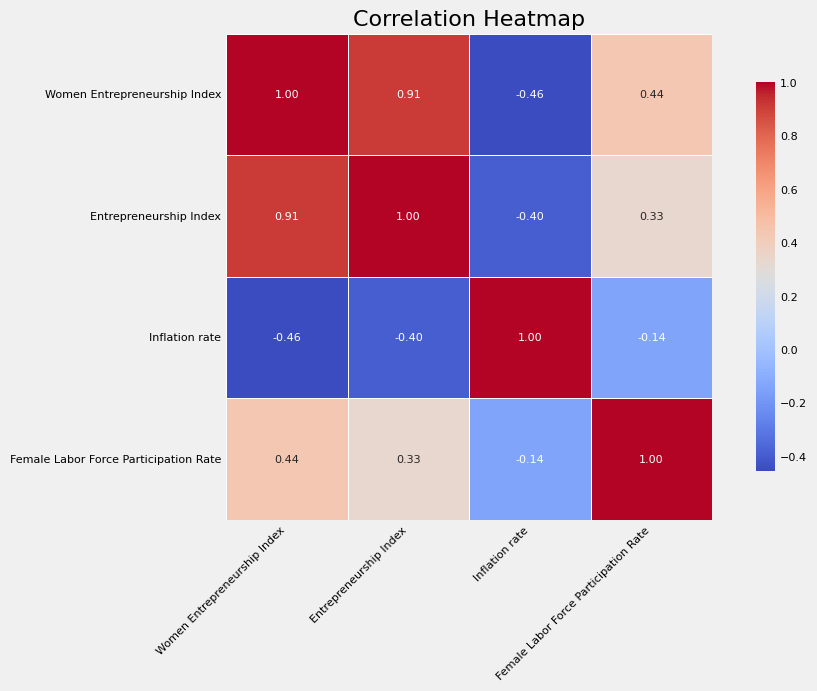

In [67]:
# Correlation Analysis
correlation_matrix = lf_w_entrepreneurship.select_dtypes(exclude=['object', 'category']).corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

The reason the Women Entrepreneurship Index (WEI) takes values between 0 and 100 lies in various factors such as standardization, ideal situation definition, academic references, and policy development. Therefore, these values are important for both comparability and meaningful analysis.

In [68]:
# Define the bins and labels
bins = [0, 20, 40, 60, 80, 100]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

wei = 'Women Entrepreneurship Index'
ei = 'Entrepreneurship Index'
lod = 'Level of development'

# Apply the grouping
lf_w_entrepreneurship['WEI_Group'] = pd.cut(
    lf_w_entrepreneurship[wei],
    bins=bins,
    labels=labels,
    right=True
)

lf_w_entrepreneurship[[wei, 'WEI_Group', lod]].head()

,Women Entrepreneurship Index,WEI_Group,Level of development
0,54.9,Medium,Developed
1,63.6,High,Developed
2,55.4,Medium,Developed
3,66.4,High,Developed
4,68.8,High,Developed


In [69]:
lf_w_entrepreneurship[lf_w_entrepreneurship['WEI_Group'] == 'High'][lod].unique(), lf_w_entrepreneurship[lf_w_entrepreneurship['WEI_Group'] == 'Medium'][lod].unique()

(array(['Developed'], dtype=object),
 array(['Developed', 'Developing'], dtype=object))

In [70]:
# Dash application
app = dash.Dash(__name__)

# Function to create the scatter plot
def create_scatter_plot(selected_group):
    fig = go.Figure()

    # Add a trace for each WEI_Group
    for group in lf_w_entrepreneurship['WEI_Group'].unique():
        filtered_df = lf_w_entrepreneurship[lf_w_entrepreneurship['WEI_Group'] == group]
        visible = True if selected_group == "All" or group == selected_group else False

        fig.add_trace(go.Scatter(
            x=filtered_df[ei],
            y=filtered_df[wei],
            mode='markers',
            marker=dict(size=filtered_df['Female Labor Force Participation Rate'] / 2, opacity=0.7),
            name=group,
            visible=visible,
            text=filtered_df['Country'],
            hovertemplate='<b>%{text}</b><br>Entrepreneurship Index: %{x}<br>Women Entrepreneurship Index: %{y}<extra></extra>'
        ))

    # Set title and axis labels
    fig.update_layout(
        title=f'{ei} vs {wei} ({selected_group})',
        xaxis_title=ei,
        yaxis_title=wei,
        width=700,
        height=500
    )
    return fig

# Application layout
app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id='wei-dropdown',
            options=[{'label': group, 'value': group} for group in ['All'] + lf_w_entrepreneurship['WEI_Group'].unique().tolist()],
            value='All',
            clearable=False,
            style={'width': '50%'}
        ),
        dcc.Graph(id='scatter-plot')
    ], style={'display': 'inline-block', 'width': '70%'}),

    html.Div(id='country-list', style={'display': 'inline-block', 'width': '25%', 'verticalAlign': 'top', 'paddingLeft': '20px'})
])

# Callbacks
@app.callback(
    [Output('scatter-plot', 'figure'),
     Output('country-list', 'children')],
    Input('wei-dropdown', 'value')
)
def update_output(selected_group):
    # Update the scatter plot
    fig = create_scatter_plot(selected_group)

    # Update the country list based on selected group
    if selected_group == "All":
        filtered_df = lf_w_entrepreneurship
    else:
        filtered_df = lf_w_entrepreneurship[lf_w_entrepreneurship['WEI_Group'] == selected_group]

    country_list = html.Ul([html.Li(country) for country in filtered_df['Country']])

    return fig, country_list

if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

**Average Women Entrepreneurship Index by Level of Development**

In [71]:
# Calculate the mean Women Entrepreneurship Index based on Level of Development
mean_index = (
    lf_w_entrepreneurship
    .groupby(lod)[wei]
    .mean()
    .reset_index()
)
# Bar chart
fig = px.bar(
    mean_index,
    x=lod,
    y=wei,
    color=lod,
    title=f'{wei} by {lod}',
    labels={wei: f'Average {wei}'},
    color_discrete_sequence=['blue', 'orange']
)
# Update layout
fig.update_layout(
    xaxis_title=lod,
    yaxis_title=f'Average {wei}',
    xaxis=dict(tickangle=0)  # Rotate x-axis labels
)

**Women Entrepreneurship Index by Level of Development and EU Membership**

In [72]:
# Calculate the mean Women Entrepreneurship Index based on Level of Development and EU Membership
mean_index = (
    lf_w_entrepreneurship
    .groupby([lod, 'European Union Membership'])[wei]
    .mean()
    .unstack()
    .reset_index()
)
# Stacked bar chart
fig = px.bar(
    mean_index,
    x=lod,
    y=mean_index.columns[1:],  # Use columns excluding the first one (index)
    title=f'{wei} by {lod} and EU Membership',
    labels={'value': f'Average {wei}', 'variable': 'EU Membership'},
    text_auto=True,  # Show values on bars
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig.update_layout(
    xaxis_title=lod,
    yaxis_title=f'Average {wei}',
    barmode='stack',  # Set bar mode to stacked
    legend_title='EU Membership',
    xaxis=dict(tickangle=0)  # Rotate x-axis labels
)


The box plot of the 'Entrepreneurship Index' reveals a broader distribution of values for Developed countries, with the lowest values near 40 and the highest close to 78. Conversely, Developing countries exhibit a more concentrated distribution, ranging from approximately 25 to 50. There is also an outlier within the Developing countries group. Overall, the average 'Entrepreneurship Index' tends to be higher for Developed countries, averaging around 66, while Developing countries generally have lower values, clustering around 32.

In [73]:
def box_plot(data, x, y, xlabel, ylabel, title):
    # Create a box plot
    fig = px.box(data, x=x, y=y,
                  title=title,
                  labels={x: xlabel, y: ylabel},
                  points="all")  # Show all points for better visibility

    # Update layout
    fig.update_layout(
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        boxmode='group'  # Group boxes together
    )
    fig.show()

# Entrepreneurship Index
box_plot(lf_w_entrepreneurship, lod, ei, lod, ei, f'{ei} by {lod}')

The 'Women Entrepreneurship Index' reveals a clear contrast between Developed and Developing countries. In Developed countries, the index tends to be higher, with values generally ranging from 40 to 75, and a typical score around 58. This suggests that women's participation in entrepreneurship is more common and better supported in these nations. On the other hand, in Developing countries, the index is more constrained, with scores typically ranging from 25 to 45, and an average around 38. This indicates that women's involvement in entrepreneurship is relatively lower in Developing countries, reflecting fewer opportunities or support structures for women entrepreneurs in these regions. The overall difference highlights a gap in entrepreneurial engagement between women in Developed and Developing countries.

In [74]:
# Women Entrepreneurship Index
box_plot(lf_w_entrepreneurship, lod, wei, lod, wei, f'{wei} by {lod}')

In developed countries, the inflation rate tends to be relatively low and stable, with most values clustered within a narrow interquartile range (IQR) close to 0, indicating low inflation variability. There is a small outlier above 5, suggesting rare instances of higher inflation. On the other hand, developing countries exhibit a much broader range of inflation rates, spanning from 0 to above 10, with a notable outlier exceeding 20. The median inflation rate in developing countries is around 5, significantly higher than in developed nations, highlighting the greater inflationary pressures that these economies often face.

In [75]:
# Inflation rate
y = 'Inflation rate'
box_plot(lf_w_entrepreneurship, lod, y, lod, y, f'{y} by {lod}')

In developed countries, the median 'Female Labor Force Participation Rate' is approximately 66, while in developing countries, it is around 60. This suggests that although there is a slight difference, female labor force participation rates in developed and developing countries are relatively close to each other. The interquartile range (IQR) for developed countries is narrower, indicating less variability, with most values clustered between 60% and 70%. In contrast, developing countries show a wider distribution, with more extreme values, including a few outliers below 20%. This suggests greater variability in female labor force participation among developing nations.

In [76]:
# Female Labor Force Participation Rate
y ='Female Labor Force Participation Rate'
box_plot(lf_w_entrepreneurship, lod, y, lod, y, f'{y} by {lod}')

**Female-to-Male Ratio in Unpaid Care Work and Corresponding Wage Gap (2014)**

The dataset indicates the gender ratio of the time women spend on unpaid care work compared to men in different countries.

In [77]:
unpaid_care_work1.sort_values(by='Female to male ratio of time devoted to unpaid care work (OECD (2014))', ascending=False).head(10)

,Entity,Code,Year,Female to male ratio of time devoted to unpaid care work (OECD (2014))
39,Mali,MLI,2014,17.29
50,Pakistan,PAK,2014,10.25
28,India,IND,2014,9.83
63,Tunisia,TUN,2014,7.49
0,Albania,ALB,2014,7.21
1,Algeria,DZA,2014,6.75
64,Turkey,TUR,2014,6.22
33,South Korea,KOR,2014,5.28
3,Armenia,ARM,2014,5.24
31,Japan,JPN,2014,4.83


In [78]:
def bar_plot_with_annotations(data, x, y, annotation, title, xlabel, ylabel):
    # Create a bar plot
    fig = go.Figure()

    # Add bars for Female to Male Ratio of Unpaid Care Work
    fig.add_trace(go.Bar(
        x=data[x],
        y=data[y],
        name='Female to Male Ratio of Unpaid Care Work',
        marker_color='blue',
        text=data[annotation],
        textposition='outside'  # Position of the annotations
    ))
    fig.update_layout(
        title=title,
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
        height=600,
        width=1600,
        showlegend=False
    )
    fig.show()

# Prepare data
entity = 'Entity'
unpaid_gap = pd.merge(
    unpaid_care_work1,
    gender_gap_average_wages[gender_gap_average_wages['Year'] == 2014],
    left_on=entity,
    right_on=entity,
    how='inner'
).drop(['Year_y', 'Code_y'], axis=1)

# Bar plot
bar_plot_with_annotations(unpaid_gap,
                          entity,
                          'Female to male ratio of time devoted to unpaid care work (OECD (2014))',
                          'Gender wage gap (%)',
                          'Female to Male Ratio of Unpaid Care Work and Gender Wage Gap (2014)',
                          'Country',
                          'Female to Male Ratio of Unpaid Care Work')

The relationship between the female-to-male ratio of time devoted to unpaid care work and the gender wage gap for different countries in 2014 shows no clear, linear connection. Countries with higher unpaid care work ratios (around 2–3) tend to cluster in a wage gap range of 0% to 30%, while some outliers, like those with negative or lower wage gaps, also exist. Countries with lower unpaid care work ratios (below 3) show more variability in their gender wage gaps, with some gaps reaching up to 30%. Although no strict correlation is observed, higher unpaid care work ratios are generally associated with smaller, yet positive, gender wage gaps. In contrast, countries with lower ratios exhibit greater variability, suggesting that factors beyond unpaid care work influence gender wage disparities.

In [79]:
def scatter_plot(data, x, y, hue, title, xlabel, ylabel):
    # Calculate the mean of column y
    y_mean = data[y].mean()

    fig = px.scatter(
        data, x=x, y=y, color=hue, title=title,
        color_continuous_scale='Viridis', labels={x: xlabel, y: ylabel}
    )

    fig.update_traces(marker=dict(size=7))
    fig.update_layout(
        title=title,
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        height=600,
        width=900,
        legend=dict(title=hue, x=1.05, y=1)  # Legend out overflowing
    )

    # Add a horizontal line at the mean of y
    fig.add_shape(type="line", x0=data[x].min(), x1=data[x].max(), y0=y_mean, y1=y_mean,
                  line=dict(color="Red", dash="dash"), name='Mean Line')
    fig.show()

scatter_plot(
    unpaid_gap,
    'Female to male ratio of time devoted to unpaid care work (OECD (2014))',
    'Gender wage gap (%)',
    entity,
    'Relationship Between Female-to-Male Ratio of Unpaid Care Work and Gender Wage Gap (2014)',
    'Female to Male Ratio of Unpaid Care Work',
    'Gender Wage Gap (%)')

**Top Income Group Analysis by Gender**

In [80]:
def bar_plot(data, y, title, x=entity, xlabel='Country', ylabel='Female Rate (%)'):
    # Create a bar plot
    fig = px.bar(data,
                 x=x,
                 y=y,
                 title=title,
                 labels={x: xlabel, y: ylabel},
                 text=y,
                 color=y,
                 color_continuous_scale='Blues')  # Optional color scale

    # Update layout for better visibility
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')  # Show values on bars
    fig.update_layout(
        xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
        height=600,
        width=1600,
        showlegend=False
    )
    fig.show()

The visuals below illustrate the ratios of women in the richest 10% and 0.1% across various countries. These representations provide insights into the presence of women in the upper-income brackets, reflecting their economic influence and power. Additionally, the data offers a comparative perspective on where countries stand in terms of gender equality in wealth distribution, shedding light on the progress or disparities in women's access to economic opportunities at the highest levels of income.

In [81]:
# Impute missing numeric values with column mean and convert to int
for col in top_income_groups.select_dtypes(include=['int', 'float']).columns:
    mean_value = top_income_groups[col].mean()
    top_income_groups[col] = top_income_groups[col].fillna(mean_value).astype(int)

# Percentage of women in the richest 10% of each country
bar_plot(
    top_income_groups,
    'Share of women in top 10%',
    'Rates of Women in the Richest 10%')

In [82]:
# Percentage of women in the richest 0.1% of each country
bar_plot(
    top_income_groups,
    'Share of women in top 0.1%',
    'Rates of Women in the Richest 0.1%')

**Female Labour Force Participation Rate and Gender Wage Gap Analysis for 2014**

In [83]:
gender_gap_average_wages[gender_gap_average_wages['Year'] == 2013].shape, gender_gap_average_wages[gender_gap_average_wages['Year'] == 2014].shape

((19, 4), (51, 4))

In [84]:
gender_gap_average_wages.Year.min(), gender_gap_average_wages.Year.max()

(1981, 2016)

In [85]:
# female_2014 = female[['Country', 'Labour force participation rate, female (% ages 15 and older) (2014)']].Country.nunique()
# 1990 - 2021

labour_cols = [col for col in female.columns.to_list() if col.startswith('Labour')]
female_melted = pd.melt(female, id_vars=['ISO3', 'Country', 'Continent', 'Hemisphere', 'HDI Rank (2021)'],
                    value_vars=labour_cols,
                    var_name='Year', value_name='Labour Force Participation Rate')

# Extract the year from the column name
female_melted['Year'] = female_melted['Year'].str.extract(r'(\d{4})')

# Set 'Year' as the index
female_melted = female_melted.set_index(['Year'])
lfpr_female_2014 = female_melted.loc[('2014')].reset_index()

# Prepare data
merged_lfpr_gap = pd.merge(
    lfpr_female_2014,
    gender_gap_average_wages[gender_gap_average_wages['Year'] == 2014],
    left_on='Country',
    right_on='Entity',
    how='inner'
).drop(['Year_y'], axis=1)
print(merged_lfpr_gap.shape)
merged_lfpr_gap.head()

(51, 10)


,Year_x,ISO3,Country,Continent,Hemisphere,HDI Rank (2021),Labour Force Participation Rate,Entity,Code,Gender wage gap (%)
0,2014,ARG,Argentina,America,Southern Hemisphere,47.0,47.600,Argentina,ARG,-3.62
1,2014,AUT,Austria,Europe,Northern Hemisphere,25.0,55.298,Austria,AUT,22.22
2,2014,BEL,Belgium,Europe,Northern Hemisphere,13.0,48.079,Belgium,BEL,6.54
3,2014,BGR,Bulgaria,Europe,Northern Hemisphere,68.0,48.608,Bulgaria,BGR,12.66
4,2014,BOL,Bolivia,America,Southern Hemisphere,118.0,61.197,Bolivia,BOL,6.18


The relationship between female labor force participation and the gender wage gap across different countries in 2014 indicates that generally, there is no clear linear trend. Countries with higher female labor participation rates do not necessarily exhibit lower gender wage gaps. In some countries where female labor force participation is higher (e.g., over 60%), the gender wage gap remains substantial, while in others, the gap is lower or even negative. This suggests that higher participation alone does not automatically lead to gender pay equity.

In [86]:
scatter_plot(
    merged_lfpr_gap,
    'Labour Force Participation Rate',
    'Gender wage gap (%)',
    'Entity',
    'Relationship Between Labour Force Participation Female and Gender Wage Gap (2014)',
    'Labour Force Participation Female',
    'Gender Wage Gap (%)')

**Maternal Mortality Ratio by Year and Top Countries (2010-2015)**

Maternal Mortality, which refers to the death of a woman during pregnancy, childbirth, or shortly after due to complications or inadequate healthcare, is notably high in certain countries. **Sierra Leone, South Sudan, Chad, Central African Republic, and Nigeria** show some of the highest maternal mortality ratios, with rates over 1,000 deaths per 100,000 live births. This highlights significant disparities in maternal healthcare access and quality, especially in these nations.

In [117]:
feature = 'Maternal Mortality Ratio (Gapminder (2010) and World Bank (2015))'
# Select and deduplicate entities
maternal_mortality[['Entity', 'Code']].drop_duplicates().merge(
    maternal_mortality.groupby('Entity')[feature].mean().reset_index(),
    on='Entity',
    how='left'
).sort_values(by=feature,ascending=False).head(5)

,Entity,Code,Maternal Mortality Ratio (Gapminder (2010) and World Bank (2015))
133,Sierra Leone,SLE,1571.111111
140,South Sudan,SSD,1317.777778
30,Chad,TCD,1273.333333
29,Central African Republic,CAF,1085.333333
111,Nigeria,NGA,1031.833333


This line plot displays the trend in the Maternal Mortality Ratio (MMR) over time. The data shows a significant decrease in MMR from the 1700s to the present. There are some fluctuations and peaks in the earlier years, indicating periods with higher maternal mortality, possibly due to limited medical knowledge and healthcare access. After the late 19th century, the decline becomes more consistent, likely reflecting advancements in maternal healthcare, improved medical practices, and increased healthcare access. The steep drop in the 20th century is particularly notable, showcasing substantial progress in reducing maternal mortality. Overall, the trend suggests that maternal health outcomes have greatly improved over the centuries.

In [89]:
mm_copy = maternal_mortality.copy()
# Calculate the average of MMR by year
mmr_mean_by_year = mm_copy.groupby('Year')[feature].mean().reset_index()

# Line plot
fig = px.line(mmr_mean_by_year,
               x='Year',
               y=feature,
               title='Maternal Mortality Ratio by Year',
               labels={'Year': 'Year',
                       feature: 'Maternal Mortality Ratio (MMR)'},
               markers=True)

# Update layout
fig.update_traces(mode='lines+markers')
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Maternal Mortality Ratio (MMR)',
    showlegend=False,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

**Yearly Average Maternal Mortality Ratio (MMR) by Continent**

When analyzing global maternal health data, it is observed that maternal mortality rates in **Africa** remain among the highest globally, with rates significantly exceeding those of other continents. This highlights the critical need for targeted interventions to enhance healthcare systems and maternal care services in the region.

In [90]:
# Get unique continents
continents = mm_copy['Continent'].unique()

# Initialize a figure
fig = go.Figure()
# Average change in mortality for each continent
for continent in continents:
    continent_df = mm_copy[mm_copy['Continent'] == continent]
    # Calculate the average MMR by year
    mean_mmr = continent_df.groupby('Year')[feature].mean().reset_index()

    # Add a line trace for each continent
    fig.add_trace(go.Scatter(
        x=mean_mmr['Year'],
        y=mean_mmr[feature],
        mode='lines+markers',
        name=continent
    ))

# Update layout
fig.update_layout(
    title='Mean Maternal Mortality Ratio by Year for Continents',
    xaxis_title='Year',
    yaxis_title='Mean Maternal Mortality Ratio',
    legend_title='Continents',
)

# Update axes to show grid lines
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

**Placement**

In the placement dataset, the status column represents the placement outcome of the students. It indicates whether a student has been successfully placed in a job after completing their education or not.

In [91]:
placement_analysis = placement.copy()
placement_analysis.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


The analysis of the placement dataset will be structured under several key headings, including Student Success and Placement Status, Education and Career Choice, Gender and Career Preferences, Education and Placement Status, Factors Affecting Success, and Education Success with Recruitment Exam. Each section will focus on relevant metrics and relationships to draw insights about student outcomes and their educational paths.

**`1.` Student Success and Placement Status**

The dataset exhibits a clear trend where students who achieved SSC and HSC grades of 80 and above are predominantly placed in jobs, while those with diploma grades below 60 are typically not placed. For students with grades between 60 and 80, the outcome is less deterministic, with both placement and non-placement observed. This distribution suggests that the dataset is well-suited for applying a machine learning model to predict job placement outcomes based on academic performance and related features.

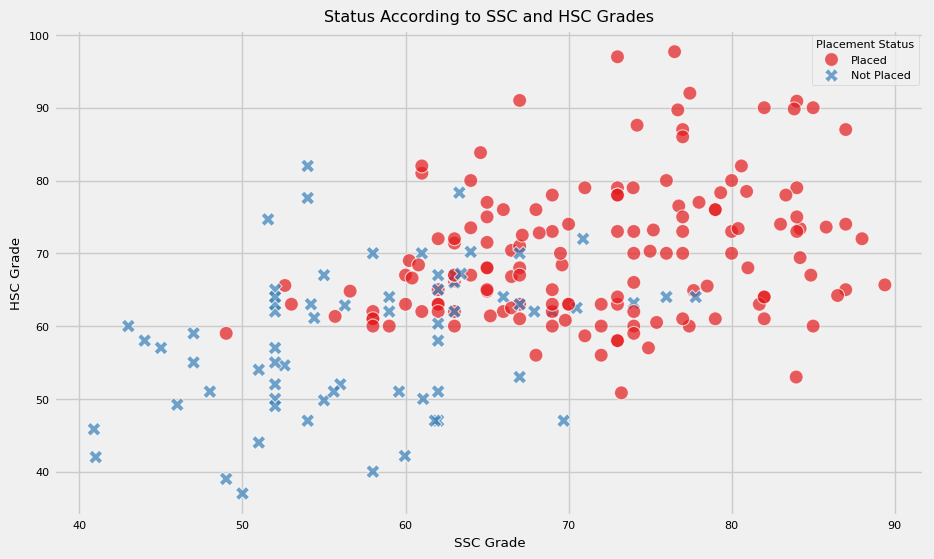

In [92]:
# Visualization of the relationship between SSC and HSC grades and placement status
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='ssc_percentage', y='hsc_percentage', hue='status',
                palette='Set1', data=placement_analysis,
                style='status', markers={'Placed': 'o', 'Not Placed': 'X'},
                s=100, alpha=0.7)  # Added markers, size, and transparency

plt.xlabel('SSC Grade')
plt.ylabel('HSC Grade')
plt.title('Status According to SSC and HSC Grades')
plt.legend(title='Placement Status')  # Add a legend title
plt.grid(True)

When university grades are grouped, it expresses the distribution of the preference list according to groups. While a large portion of those with a bachelor's degree percentage (58.2 - 74.6] specialize in Mkt&HR and Mkt&Fin fields, the Mkt&HR selection of students with a percentage above 74.6 has decreased significantly. It is seen that students with a degree in the percentage (82.8, 91.0] are few in these two fields.

In [93]:
def count_plot(data, x, hue, xlabel, ylabel, title):
    data[x] = data[x].astype(str)
    # Count plot
    fig = px.histogram(data, x=x, color=hue,
                       title=title,
                       labels={x: xlabel, hue: ylabel},
                       barmode='group')  # Group bars by hue
    fig.show()

# Grouping operation to convert university grades to categorical variables
placement_analysis['degree_percentage_group'] = pd.cut(placement_analysis['degree_percentage'], bins=5)

# Create the count plot
count_plot(
    placement_analysis,
    'degree_percentage_group',
    'specialisation',
    'University Grade Group',
    'Number of Students',
    'Relationship between University Grade Group and Specialization Preference'
)

Approximately 40% of employees specializing in marketing and human resources -Mkt&HR- are women and 60% are men. 33.3% of employees specializing in marketing and finance -Mkt&Fin- are women and 66.7% are men.

In [94]:
# Relationship between gender and specialization preference
count_plot(
    placement_analysis,
    'specialisation',
    'gender',
    'Specialization Preference',
    'Number of Students',
    'Relationship between Gender and Specialization Preference')

**`2.` Education and Placement Status**

While the lower extreme degree_percentage value is ~56 and the upper extreme is ~82 in the Placed data set, the lower extreme value is ~50 and the upper extreme value is ~75 in the Not Placed data set. There are outliers in both data sets. In general, the bachelor's degree percentage of students who are placed in a job is ~68, while this value is ~61 for students who are not placed in a job.

In [95]:
# Relationship between university success and employment status
box_plot(
    placement_analysis,
    'status',
    'degree_percentage',
    'Employment Status',
    'University Grade',
    'Relationship Between University Success and Employment Status')

**`3.` Factors Affecting Success**

When the effect of education certificate percentages on success is measured, it is seen that 22.2% (R-squared) of the independent variables (ssc_percentage, hsc_percentage, degree_percentage) have an effect on the performance in the MBA program (mba_percent). When the p values ​​supporting the F-statistic are examined, they are less than 0.05, indicating that the model is statistically significant. Of course, when more independent variables are added, the model will improve by 0.211 (Adj. R-squared).

In [96]:
# Regression analysis of the factors affecting success
X = placement_analysis[['ssc_percentage', 'hsc_percentage', 'degree_percentage']] # Independent variables
X = sm.add_constant(X)

y = placement_analysis['mba_percent'] # Target variable

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            mba_percent   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     20.03
Date:                Sat, 02 Nov 2024   Prob (F-statistic):           1.85e-11
Time:                        10:03:25   Log-Likelihood:                -656.81
No. Observations:                 215   AIC:                             1322.
Df Residuals:                     211   BIC:                             1335.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                37.6529      3.33

**`4.` Education Success with Recruitment Exam**

When the relationship between the recruitment exam score and education certificate percentages is examined, the chance of being hired for candidates with low recruitment scores seems higher for those with SSC percentages >= 80 compared to HSC and Degree percentages. Even if the recruitment exam score is high, if the education certificate percentages are below average, the chance of being hired seems low.

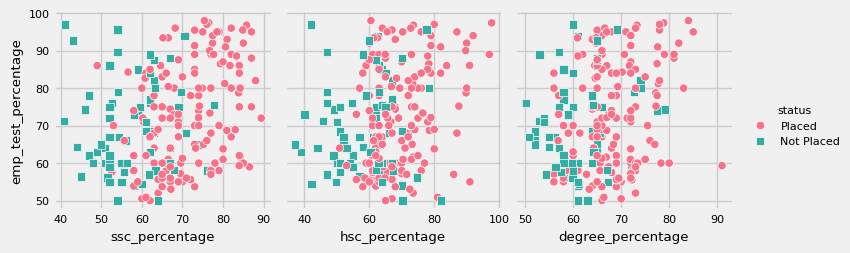

In [97]:
selected_placement = placement_analysis[['gender', 'ssc_percentage', 'hsc_percentage', 'degree_percentage', 'emp_test_percentage', 'specialisation', 'status']]


# Relationship between emp_test_percentage and other variables
sns.pairplot(selected_placement, x_vars=['ssc_percentage', 'hsc_percentage', 'degree_percentage'], y_vars=['emp_test_percentage'], hue='status', markers=['o', 's'], palette='husl')
plt.show()

# **`5.` Classification Modelling**

## **`1.` Explain Data**

Using the placement dataset, a classification task can be performed with the status column as the target variable. The goal of this task is to predict whether a student will be placed "Placed" or not placed "Not Placed" in a job based on various features in the dataset. These features include academic performance, work experience, and other educational factors, such as:

- **ssc_percentage:** Secondary School Certificate (SSC) percentage.
- **ssc_board:** The board under which SSC was completed (e.g., Central, Others).
- **hsc_percentage:** Higher Secondary Certificate (HSC) percentage.
- **hsc_board:** The board under which HSC was completed.
- **hsc_subject:** The subject studied during HSC (e.g., Commerce, Science, Arts).
- **degree_percentage:** Percentage in the undergraduate degree.
- **undergrad_degree:** The type of undergraduate degree (e.g., Sci&Tech, Comm&Mgmt).
- **work_experience:** Whether the student has prior work experience (Yes/No).
- **emp_test_percentage:** Employment test percentage.
- **specialisation:** Specialization in MBA (e.g., Marketing & HR, Marketing & Finance).
- **mba_percent:** Percentage obtained in the MBA program.

In [98]:
placement.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


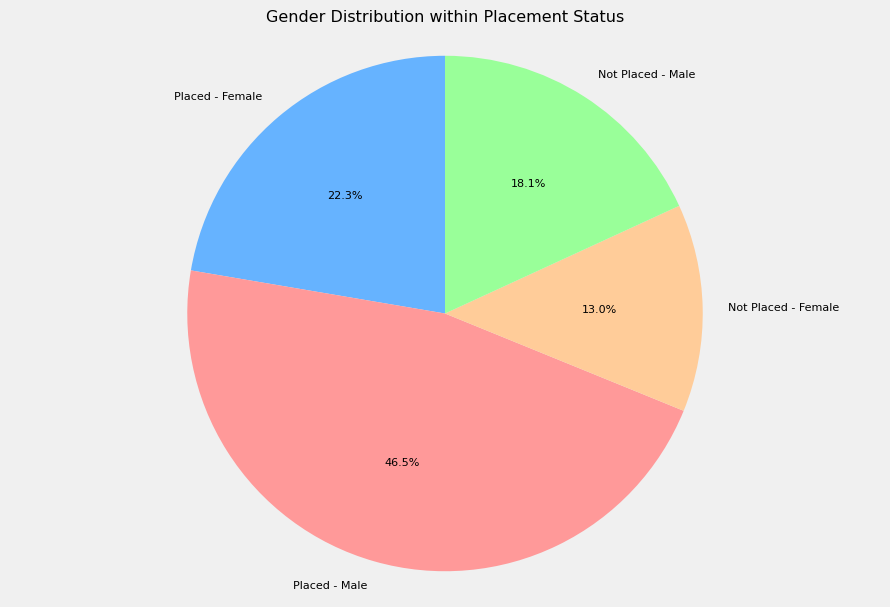

In [99]:
# Define the target variable
target = 'status'

# Distribution of "status"
status_counts = placement[target].value_counts()

# Distribution of "gender" for each status
gender_counts = placement.groupby(target)['gender'].value_counts().unstack(fill_value=0)

# Prepare data
placed_counts = gender_counts.loc['Placed']
not_placed_counts = gender_counts.loc['Not Placed']

# Define pie chart labels and sizes
labels = ['Placed - Female', 'Placed - Male', 'Not Placed - Female', 'Not Placed - Male']
sizes = [placed_counts['F'], placed_counts['M'], not_placed_counts['F'], not_placed_counts['M']]
colors = ['#66b3ff', '#ff9999', '#ffcc99', '#99ff99']

# Visualization
plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Gender Distribution within Placement Status')
plt.axis('equal')
plt.show()

In [100]:
# Prepare data
seed=42
X = placement.drop(target, axis=1)
y = placement[target]

# Encode the target feature
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)

In [101]:
def print_bold(text):
    print(f"\033[1m{text}\033[0m", end="")

def cat_num_features(df):
    cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    num_features = df.select_dtypes(exclude=['object', 'category']).columns.tolist()
    return cat_features, num_features

cat_features, num_features = cat_num_features(X_train)
print(f"Categorical Features: {cat_features}")
print(f"Numerical Features: {num_features}")

Categorical Features: ['gender', 'ssc_board', 'hsc_board', 'hsc_subject', 'undergrad_degree', 'work_experience', 'specialisation']
Numerical Features: ['ssc_percentage', 'hsc_percentage', 'degree_percentage', 'emp_test_percentage', 'mba_percent']


## **`2.` Generate Features**

In [102]:
def Find_K_with_elbow(df, start=2, end=10, vis=False):
    wcss_values = []
    for i in range(start, end):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=seed, n_init="auto")
        kmeans.fit(df)
        wcss_values.append(kmeans.inertia_)  # WCSS values

    # Calculate WCSS differences
    wcss_diff = np.diff(wcss_values)  # 1st degree differences
    wcss_diff_abs = np.abs(wcss_diff)  # Absolute value of differences

    # Elbow point:
    elbow_point = np.argmax(wcss_diff_abs) + 1 + start  # Largest absolute difference

    if vis:
        plt.figure(figsize=(6, 4))
        plt.plot(range(start, end), wcss_values, marker='o', linestyle='--', color='blue', label='WCSS')
        plt.axvline(x=elbow_point, color='red', linestyle='--', label='Elbow Point')
        plt.xlabel("Number of Clusters")
        plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
        plt.title("WCSS vs. Number of Clusters (Elbow Method)")
        plt.legend()
        plt.show()

    return elbow_point, wcss_values[elbow_point - start]

In [103]:
group_features = []
for f in num_features:
    group_features.append({'feature': f, 'n_cluster': 0})

for group in group_features:
    feature = group['feature']
    print_bold(f'K-Means Analysis for {feature}')

    elbow_point, min_wcss_at_elbow = Find_K_with_elbow(X_train[[feature]])

    group['n_cluster'] = elbow_point
    print(f"Elbow Point: {elbow_point}")
    # print(f"Minimum WCSS at Elbow: {min_wcss_at_elbow}")


K-Means Analysis for ssc_percentageElbow Point: 3
K-Means Analysis for hsc_percentageElbow Point: 3
K-Means Analysis for degree_percentageElbow Point: 3
K-Means Analysis for emp_test_percentageElbow Point: 3
K-Means Analysis for mba_percentElbow Point: 3


In [104]:
def feature_groups_function(train, test=None, feature=None, n_clusters=3):
    train_data = train.copy()
    test_data = test.copy() if test is not None else None

    if feature is None:
        raise ValueError("Feature name must be provided.")
    if feature not in train_data.columns:
        raise ValueError(f"The feature '{feature}' is not in the training data.")
    if train_data[feature].isnull().any():
        raise ValueError(f"The feature '{feature}' contains null values. Please handle missing values before clustering.")
    # New column for the group
    group_feature = f'{feature}_group'
    print_bold(f'K-Means Groups for {feature} w n_clusters: {n_clusters}:\n')

    # Model initialization
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    train_data[group_feature] = kmeans.fit_predict(train_data[[feature]])
    train_data[group_feature] = train_data[group_feature].astype('category')

    # Davies-Bouldin score
    dbi = davies_bouldin_score(train_data[[feature]], kmeans.labels_)
    # Silhouette score
    score = silhouette_score(train_data[[feature]], kmeans.labels_)
    print(f"Silhouette Score: {score}")
    print(f"Davies-Bouldin Index: {dbi}\n")

    if test_data is not None:
        test_data[group_feature] = kmeans.predict(test_data[[feature]])
        test_data[group_feature] = test_data[group_feature].astype('category')

    return train_data, test_data

The clustering results for the various percentages indicate that grouping these features using K-Means is sensible.

In [105]:
for i, group in enumerate(group_features):
    feature = group['feature']
    n_cluster = group['n_cluster']

    vis = False
    if i == 0:
        vis=True
    X_train, X_val = feature_groups_function(X_train, test=X_val, feature=feature, n_clusters=n_cluster)

K-Means Groups for ssc_percentage w n_clusters: 3:
Silhouette Score: 0.5841781828532874
Davies-Bouldin Index: 0.5017096148273558

K-Means Groups for hsc_percentage w n_clusters: 3:
Silhouette Score: 0.5644899877583202
Davies-Bouldin Index: 0.5426161773024093

K-Means Groups for degree_percentage w n_clusters: 3:
Silhouette Score: 0.5734925203072057
Davies-Bouldin Index: 0.5039833213249506

K-Means Groups for emp_test_percentage w n_clusters: 3:
Silhouette Score: 0.5976828310599079
Davies-Bouldin Index: 0.49437819269175926

K-Means Groups for mba_percent w n_clusters: 3:
Silhouette Score: 0.5338580033563202
Davies-Bouldin Index: 0.5439344611484418



In [106]:
def generate_other_features(df):
    # Change in Student's Grades
    df['percentage_diff'] = df['ssc_percentage'] - df['hsc_percentage']
    # Average Performance Across the Student's Education
    df['performance_consistency'] = (df['ssc_percentage'] + df['hsc_percentage'] + df['degree_percentage']) / 3
    return df

X_train = generate_other_features(X_train)
X_val = generate_other_features(X_val)

In [107]:
X_train.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,ssc_percentage_group,hsc_percentage_group,degree_percentage_group,emp_test_percentage_group,mba_percent_group,percentage_diff,performance_consistency
120,M,58.0,Others,40.0,Others,Science,59.0,Comm&Mgmt,No,73.00,Mkt&HR,58.81,0,1,0,2,2,18.0,52.333333
29,M,62.0,Central,67.0,Central,Commerce,58.0,Comm&Mgmt,No,77.00,Mkt&Fin,51.29,1,2,0,2,2,-5.0,62.333333
19,M,60.0,Others,67.0,Others,Arts,70.0,Comm&Mgmt,Yes,50.48,Mkt&Fin,77.89,1,2,2,0,1,-7.0,65.666667
69,M,73.0,Central,73.0,Central,Science,66.0,Sci&Tech,Yes,70.00,Mkt&Fin,68.07,2,2,2,2,1,0.0,70.666667
97,F,70.5,Central,62.5,Others,Commerce,61.0,Comm&Mgmt,No,93.91,Mkt&Fin,69.03,1,2,0,1,1,8.0,64.666667


In [108]:
cat_features, num_features = cat_num_features(X_train)
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    if X_val is not None:
        X_val[col] = X_val[col].astype(str)


## **`3.` Modelling**

In [109]:
def plot_auc(y_true, y_scores):
    # ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    # AUC
    roc_auc = auc(fpr, tpr)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random prediction line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()

In [110]:
def build_model(X_train, X_val, params={}, plot=True):
    cat_features, num_features = cat_num_features(X_train)

    # Pool
    train_pool = Pool(X_train,
                      label=y_train,
                      cat_features=cat_features)
    val_pool = Pool(X_val,
                    label=y_val,
                    cat_features=cat_features)

    # Model initialization
    model = CatBoostClassifier(**params, custom_metric=['AUC', 'F1'], random_seed=seed, verbose=False)
    # Model training
    model.fit(train_pool, eval_set=val_pool, verbose=500, plot=True, use_best_model=True)

    # Evaluation
    best_score = model.get_best_score()
    print(f"Best Score: {best_score}\n")

    # Check metrics
    if 'validation' in best_score:
        if 'AUC' in best_score['validation']:
            print(f"AUC: {best_score['validation']['AUC']}")
        if 'F1' in best_score['validation']:
            print(f"F1 Score: {best_score['validation']['F1']}")
        if 'Accuracy' in best_score['validation']:
            print(f"Accuracy: {best_score['validation']['Accuracy']}")
    else:
        print("Validation metrics not found in the best score.")

    # Get the predictions
    y_scores = model.predict_proba(val_pool)[:, 1]  # Positive class prediction probabilities
    y_true = val_pool.get_label()

    if plot:
        # Plot AUC
        plot_auc(y_true, y_scores)

    return model

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.020183
0:	learn: 0.6741786	test: 0.6789913	best: 0.6789913 (0)	total: 66.5ms	remaining: 1m 6s
500:	learn: 0.0400912	test: 0.4028838	best: 0.3742733 (250)	total: 11.5s	remaining: 11.4s
999:	learn: 0.0164814	test: 0.4662663	best: 0.3742733 (250)	total: 20.8s	remaining: 0us

bestTest = 0.3742732559
bestIteration = 250

Shrink model to first 251 iterations.
Best Score: {'learn': {'F1': 1.0, 'Logloss': 0.016481422195703404}, 'validation': {'F1': 0.8837209302325583, 'Logloss': 0.37427325591229904, 'AUC': 0.9107142857142857}}

AUC: 0.9107142857142857
F1 Score: 0.8837209302325583


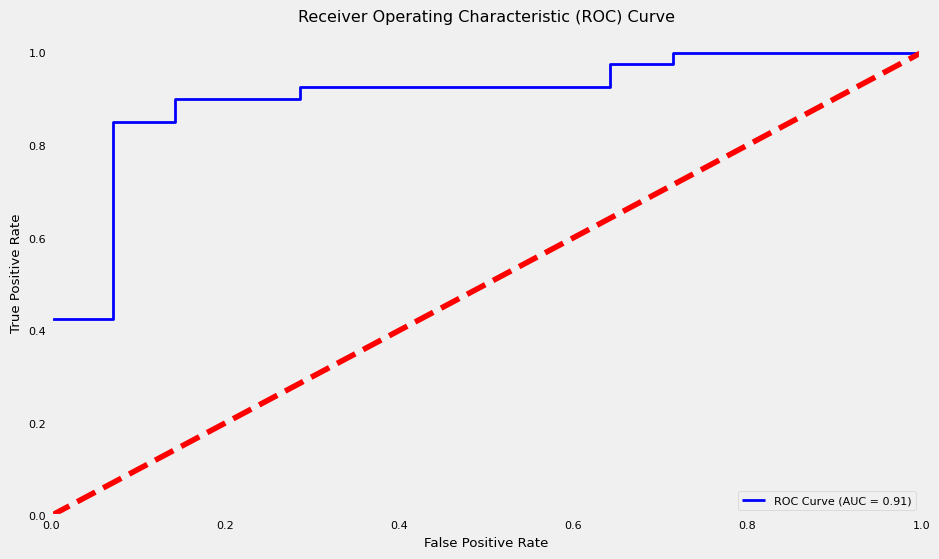

In [111]:
model = build_model(X_train, X_val)

In [112]:
feature_importance = model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,performance_consistency,18.355712
1,ssc_percentage,9.767162
2,degree_percentage,9.693350
3,ssc_percentage_group,8.814194
4,mba_percent,8.562358
5,hsc_percentage,7.327737
6,hsc_percentage_group,6.198302
7,degree_percentage_group,5.824875
8,mba_percent_group,4.686165
9,work_experience,4.283951


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.020183
0:	learn: 0.6750260	test: 0.6783255	best: 0.6783255 (0)	total: 59.7ms	remaining: 59.7s
500:	learn: 0.0422805	test: 0.4042342	best: 0.3790001 (165)	total: 7.76s	remaining: 7.73s
999:	learn: 0.0145373	test: 0.4594558	best: 0.3790001 (165)	total: 10.3s	remaining: 0us

bestTest = 0.3790001208
bestIteration = 165

Shrink model to first 166 iterations.
Best Score: {'learn': {'F1': 1.0, 'Logloss': 0.01453725908303826}, 'validation': {'F1': 0.9069767441860466, 'Logloss': 0.37900012081128537, 'AUC': 0.9107142857142857}}

AUC: 0.9107142857142857
F1 Score: 0.9069767441860466


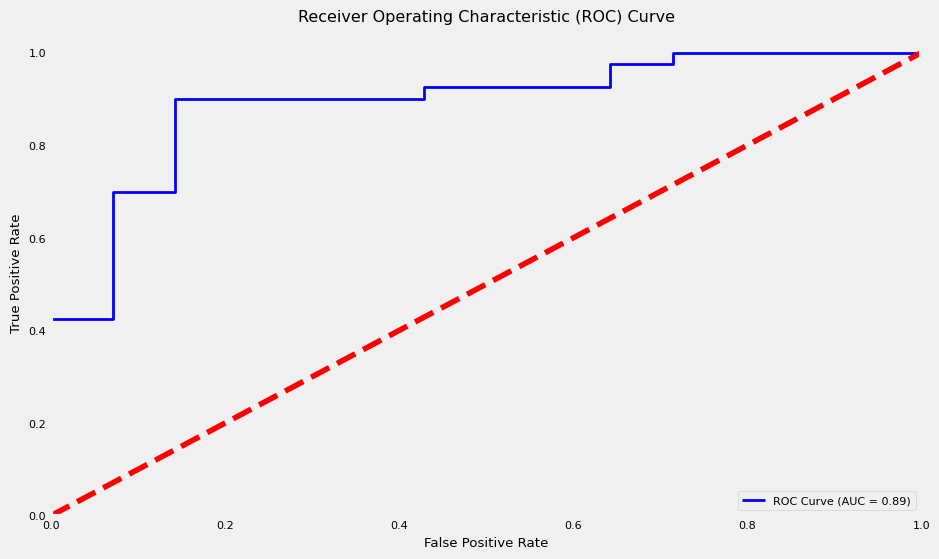

In [113]:
selected_features = feature_importance[feature_importance['Importances'] > 1].sort_values(by='Importances', ascending=False)['Feature Id'].to_list()
if X_val is not None:
    _ = build_model(X_train[selected_features], X_val[selected_features])

In [ ]:
# Define the model
cat_model = CatBoostClassifier(random_state=seed, verbose=0)

# Set up parameter grid for tuning
param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7],
}
t1 = datetime.now()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid,
                           scoring='accuracy', cv=5)

cat_features, num_features = cat_num_features(X_train[selected_features])

# Perform the grid search
grid_search.fit(X_train[selected_features], y_train, cat_features=cat_features)

best_params = grid_search.best_params_
# Output the best parameters and score
print("Best Parameters:", best_params)
print("Best Accuracy:", grid_search.best_score_)

t2 = datetime.now()
print(f"Training time: {t2-t1}\n")
# # best_params = {'depth': 4, 'iterations': 500, 'l2_leaf_reg': 7, 'learning_rate': 0.01}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6286201	test: 0.6391224	best: 0.6391224 (0)	total: 8.87ms	remaining: 4.43s
499:	learn: 0.0098700	test: 0.4802895	best: 0.3564417 (68)	total: 3.22s	remaining: 0us

bestTest = 0.356441668
bestIteration = 68

Shrink model to first 69 iterations.
Best Score: {'learn': {'F1': 1.0, 'Logloss': 0.009869982639086186}, 'validation': {'F1': 0.9069767441860466, 'Logloss': 0.3564416680313443, 'AUC': 0.9232142857142858}}

AUC: 0.9232142857142858
F1 Score: 0.9069767441860466


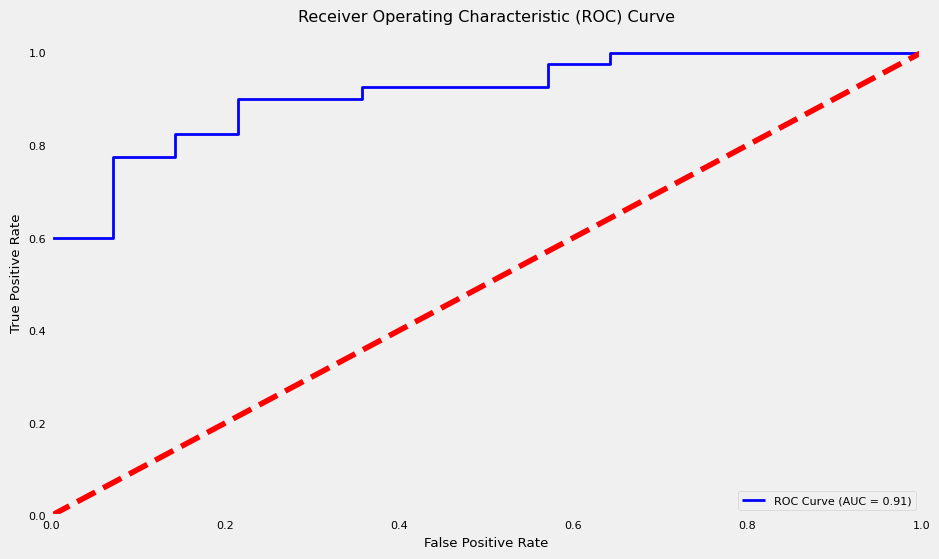

In [115]:
# Train with the best params
best_params = {'iterations': 500, 'l2_leaf_reg': 7, 'learning_rate':0.1}

if X_val is not None:
    _ = build_model(X_train[selected_features], X_val[selected_features], params=best_params)

# **`6.` Results**

The model's performance was evaluated using several metrics after performing parameter tuning. The Area Under the Curve (AUC) score achieved was **0.9232**, indicating a strong ability to distinguish between the positive and negative classes. Additionally, the F1 Score was calculated at **0.9070**, demonstrating a good balance between precision and recall. These results suggest that the model is effective in making accurate predictions.

# **`7.` Conclusion**

In summary, the model exhibits strong performance metrics, with both AUC and F1 Score indicating its reliability in classification tasks. The careful selection of features and thorough parameter tuning have contributed to these positive outcomes. Future work may involve further refinement of the model and testing it on additional datasets to validate its generalizability.